# Data Exploration and Preprocessing

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

## 1. Load Data

### 1.1 Data loading helper functions

In [56]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def convEncoding(input):
    result = []
    for code in input:
        inner = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        inner[code] = 1.0
        result.append(inner)

    return result

def normalize(x):
    maximum = np.max(x)
    minimum = np.min(x)
    return(x - minimum) / (maximum - minimum)

# This is the function that returns data
# The load_data() function returns the label that is NOT one-hot encoding
def load_data(norm = False):
    files = [data_dir + str(i) for i in range(1, 6)]
    files_test = data_dir_test + 'test_batch'
    data_batch = unpickle(files[0])
    data_batch_test = unpickle(files_test)

    # image_data: the numpy array of combined image data from 5 batch files
    image_data = data_batch[b'data']
    image_data_test = data_batch_test[b'data']

    # label_data: array of labels combined from 5 batch files
    label_data = data_batch[b'labels']
    label_data_test = data_batch_test[b'labels']

    for file in files[1:5]:
        data_batch = unpickle(file)
        image_data = np.concatenate((image_data, data_batch[b'data']), axis=0)
        label_data += data_batch[b'labels']

    images_train = image_data
    images_test = image_data_test

    labels_train = np.asarray(label_data)
    labels_test = np.asarray(label_data_test)
    
    # read in names of classes
    class_names = ['airplane','automobile','bird','cat',
                   'deer','dog','frog','horse','ship','truck']

    if (norm == True):
        images_train = normalize(images_train)
        images_test = normalize(images_test)

    return images_train, images_test, labels_train, labels_test, class_names


### 1.2 Load Data

In [57]:
data_dir = "D:/AML/FinalProject/data/cifar-10-batches-py/data_batch_"
data_dir_test = "D:/AML/FinalProject/data/cifar-10-batches-py/"
# labels are not one-hot-encoding!
images_train, images_test, labels_train, labels_test, class_names = load_data()
print("Data loaded: ")
print("==>training data shape:", images_train.shape)
print("==>test data shape:", images_test.shape)

Data loaded: 
==>training data shape: (50000, 3072)
==>test data shape: (10000, 3072)


## 2. Examine Dataset

### 2.1 Data exploration helper functions

In [79]:
def reshape(images, width):
    
    '''reshape the input into 32x32x3 np.ndarray'''
    
    # input images should be a 2-dimensional np.array 
    # e.g: [[1,2,3,...]] for one image only
    first = images.shape[0]
    result = np.zeros((first, width, width, 3))
    index = 0
    for image in images:
#         assert len(image) == width*width*3
        # Get color out of original array
        redPixel = image[0:width*width]/255
        greenPixel = image[width*width:width*width*2]/255
        bluePixel = image[width*width*2:width*width*3]/255
        reshaped = np.zeros((32, 32, 3))
        for i in range(0, width): #row
            for j in range(0, width): #column
                point = np.zeros(3)
                point[0] = redPixel[i*32+j]
                point[1] = greenPixel[i*32+j]
                point[2] = bluePixel[i*32+j]
                # add to result
                reshaped[i][j] = point
        result[index] = reshaped
        index += 1
            
    return result

In [112]:
def plot_images(images, TrueClass, PredClass=None, width=32, isReshape=True):
    
    '''show images: 
    input np.ndarray, output images with true or predicted class labels'''

#     assert len(images) == len(TrueClass) == 10

    # Each image as a sub-plot: totally 2 rows 5 columns
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    if isReshape:
        reshaped_images = reshape(images, width)
    else:
        reshaped_images = images

    for i, ax in enumerate(axes.flat):
        # Plot image and smooth it
        ax.imshow(reshaped_images[i],
                   interpolation='spline16')
            
        # Name of the true class.
        TrueName = class_names[TrueClass[i]]

        if PredClass is None:
            # Only show True class names
            xlabel = "True: {0}".format(TrueName)
        else:
            # Show both True and Pred class names
            PredName = class_names[PredClass[i]]
            xlabel = "True: {0}\nPred: {1}".format(TrueName, PredName)

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

### 2.2 Reshape data

Original CIFAR 10 dataset has (,3072) numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

Here we reshape each row into a (32,32,3) numpy array, with one inner array as one pixel with three channels: red, green and blue. 

In [81]:
images_train_reshaped = reshape(images_train, 32)
images_test_reshaped = reshape(images_test, 32)
print("Data reshaped: ")
print("==>training data reshaped:", images_train_reshaped.shape)
print("==>test data reshaped:", images_test_reshaped.shape)

Data reshaped: 
==>training data reshaped: (50000, 32, 32, 3)
==>test data reshaped: (10000, 32, 32, 3)


#### Show first 10 images in training dataset

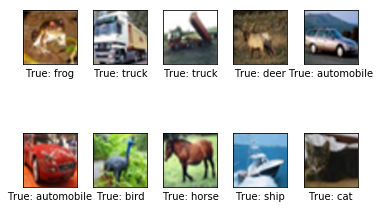

In [114]:
fig = plt.figure()
plot_images(images_train[0:10], labels_train[0:10])
fig.set_dpi(200)


## 3. Data Preprocessing

### 3.1 Data preprocessing helper functions

We inflate the size of training dataset by adding randomly distorted images which are cropped, flipped, or adjusted in terms of hue, contrast and saturation. We got this idea of data preprocessing from [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/).

The test dataset will be images cropped around center without any other adjustment. The cropped size is the same as in training set.

In [8]:
def distorted_image(image, cropped_size, training):    
    '''This function takes a single image from training set as input'''
    
    if training:
        # Randomly crop the input image.
        image = tf.random_crop(image, size=[cropped_size, cropped_size, 3])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)

        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    
    else:
        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
    
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=cropped_size,
                                                       target_width=cropped_size)
    
    return image



def preprocess(images,cropped_size,training):   
    '''This function takes multiple images as input,
    will call distorted_image()'''

    images = tf.map_fn(lambda image: distorted_image(image, cropped_size,training), images)
    
    return images


### 3.2 Distorte Dataset

In [223]:
cropped_size = 24
print('cropped size:', cropped_size)
print("===Start to distort images in training and test===")
preprocessed_train = preprocess_train(images_train_reshaped, 24)
print("->Finish Preprocessing Data in Train Set")
print("  Preprocessed training set shape:", preprocessed_train.shape)
print("  Preprocessed training set type:", type(preprocessed_train))
preprocessed_test = preprocess_test(images_test_reshaped, 24)
print("->Finish Preprocessing Data in Test Set")
print("  Preprocessed test set shape:", preprocessed_test.shape)
print("  Preprocessed test set type:", type(preprocessed_test))
        

cropped size: 24
===Start to distort images in training and test===
->Finish Preprocessing Data in Train Set
  Preprocessed training set shape: (50000, 24, 24, 3)
  Preprocessed training set type: <class 'tensorflow.python.framework.ops.Tensor'>
->Finish Preprocessing Data in Test Set
  Preprocessed test set shape: (10000, 24, 24, 3)
  Preprocessed test set type: <class 'tensorflow.python.framework.ops.Tensor'>


In [115]:
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 10, axis=0)

    # Create a feed-dict for TensorFlow.
    feed_dict = {x: image_duplicates}

    # Calculate only the pre-processing of the TensorFlow graph
    # which distorts the images in the feed-dict.
    result = sess.run(distorted_images, feed_dict=feed_dict)
#     print(result.shape)

    # Plot the images.
    plot_images(result, TrueClass=np.repeat(cls_true, 10), isReshape=False)
    
def get_test_image(i):
    return images_test_reshaped[i, :, :, :], labels_test[i]

#### Plot Distorted Images

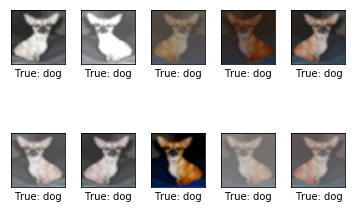

In [123]:
with tf.Graph().as_default():
    x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='x')
    sess = tf.Session()
    distorted_images = preprocess(x, 32, training=True)
    img, cls = get_test_image(321)
#     print(img.shape)
    plot_distorted_image(img, cls)